# Model Training, Optimization and Quantization with MONAI, PyTorch Lightning and OpenVINO

This tutorial shows how to train a [MONAI](https://monai.io/) classification model on a [MedMNIST](https://medmnist.com/) dataset, and quantize the model with [NNCF](https://github.com/openvinotoolkit/nncf).

To run this notebook, please create a virtual environment with Python 3.7 or 3.8, with `python -m venv monai_env` (on Linux use `python3`) and install the requirements with `pip install -r requirements.txt`.

## Supported Networks and Datasets

The following MONAI Classification Networks are supported in this notebook:

`["DenseNet","SENet154", "SEResNet50",  "SEResNext50"]`. 

The variants of these networks `"DenseNet121", "DenseNet169", "DenseNet201", "DenseNet264",  "SEResNet101", "SEResNet152", "SEResNext101"` also work. 

All MedMNIST datasets for multi-class and binary-class classification are supported: `['pathmnist', 'dermamnist', 'octmnist', 'pneumoniamnist', 'breastmnist', 'bloodmnist', 'tissuemnist', 'organamnist', 'organcmnist', 'organsmnist', 'organmnist3d', 'nodulemnist3d', 'adrenalmnist3d', 'fracturemnist3d', 'vesselmnist3d', 'synapsemnist3d']`

## Imports

In [120]:
import datetime
import inspect
import logging
import os
import random
import subprocess
import warnings
from operator import itemgetter
from pathlib import Path
from typing import Dict, Optional, Sequence, Tuple

import dateutil
import matplotlib.pyplot as plt
import monai
import monai.networks.nets as nets
import nncf  # must be imported after torch
import numpy as np
import pytorch_lightning as pl
import torch
from IPython.display import Markdown, display
from monai.metrics import ConfusionMatrixMetric
from monai.transforms import (
    Activations,
    AddChannel,
    AsChannelFirst,
    AsDiscrete,
    Compose,
    ToTensor,
)
from nncf import NNCFConfig
from nncf.common.utils.logger import set_log_level
from nncf.torch import create_compressed_model, register_default_init_args
from openvino.inference_engine import IECore
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.model_summary import summarize
from sklearn.metrics import classification_report
from torch.jit import TracerWarning
from torch.utils.data import DataLoader as TorchDataLoader
from torch.utils.data import Dataset

import medmnist
from medmnist import Evaluator

## Dataset, Metric and Model

We start by defining a Dataset and DataModule to handle data transformation and loading, a Metric class that specifies how to evaluate the model, and the PyTorch Lightning Model that specifies the MONAI model to use and contains the training and evaluation code.

### Data

We create a Monai Dataset to load and transform the data, and a PyTorch Lighnting DataModule for accessing this data during training. The dataset returns data as a tuple consisting of (image, mask, image_metadata, mask_metadata).

We use Monai Transforms to transform and augment the data during training. During training, we randomly rotate the data, add noise, and shift pixel values. Monai's ImageDataset ensures that the random seed for the image and segmentation mask transform are the same, and therefore that for the random rotation transforms, image and mask will be rotated in the same way. During validation, we only make sure that the dimensions and data type are correct.

The specified MedMNIST dataset is downloaded if it has not been downloaded before. See the top of this notebook for the supported datasets

#### Dataset

In [2]:
class MedMNISTDataset(Dataset):
    def __init__(self, medmnist_dataset: str, split: str) -> None:

        supported_datasets = [
            (ds_name)
            for (ds_name, ds_info) in medmnist.INFO.items()
            if ds_info["task"] in ["multi-class", "binary-class"]
        ]

        if medmnist_dataset not in supported_datasets:
            raise ValueError(
                f"{medmnist_dataset} is not a supported dataset. Supported datasets are: "
                f"{supported_datasets}."
            )

        dataset = getattr(
            medmnist, medmnist.dataset.INFO[medmnist_dataset]["python_class"]
        )
        self.num_dims = 3 if medmnist_dataset.endswith("3d") else 2
        self.num_channels = medmnist.dataset.INFO[medmnist_dataset]["n_channels"]
        self.labels = medmnist.dataset.INFO[medmnist_dataset]["label"]
        self.num_classes = len(self.labels)

        transforms = [ToTensor(dtype=torch.float)]
        # transforms = []
        if self.num_channels == 3:
            transforms.append(AsChannelFirst())
        elif self.num_dims == 2:
            transforms.append(AddChannel())

        transform = Compose(transforms)

        print(
            f"Setup {medmnist_dataset} {split}, {self.num_channels} channels, "
            f"{self.num_classes} classes"
        )
        split_dataset = dataset(split=split, transform=None, download=True)

        data = [
            (transform(np.asarray(item[0])), torch.as_tensor(item[1]))
            for item in split_dataset
        ]
        self.data = data

    def __len__(self) -> int:
        """
        Returns the number of elements in the dataset
        """
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get item from self.dataset at the specified index.
        Returns (annotation, image), where annotation is a tuple (index, class_index)
        and image a preprocessed image in network shape

        :param index: Index of dataset item to get
        :returns: (image, label)
        """
        image, label = self.data[index]
        image = torch.as_tensor(image, dtype=torch.float)
        label = torch.as_tensor(label, dtype=torch.float)
        return image, label

#### PyTorch Lightning DataModule

A [Lightning DataModule]( https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html) defines dataloaders and connects the Lightning Module to the Dataset. 

In [3]:
class DataModule(pl.LightningDataModule):
    def __init__(self, medmnist_dataset: str, batch_size: int):
        """
        DataModule for MedMNIST Dataset

        :param medmnist_dataset: MedMNIST dataset name. Example: breastmnist
        :param batch_size: batch size
        """
        super().__init__()
        self.medmnist_dataset = medmnist_dataset
        self.batch_size = batch_size

    def setup(self, stage=None):
        random.seed(1.414213)

        self.dataset_train = MedMNISTDataset(self.medmnist_dataset, "train")
        self.dataset_val = MedMNISTDataset(self.medmnist_dataset, "val")
        self.dataset_test = MedMNISTDataset(self.medmnist_dataset, "test")

        print(f"Setup train dataset: {len(self.dataset_train)} items")
        print(f"Setup val dataset: {len(self.dataset_val)} items")
        print(f"Setup test dataset: {len(self.dataset_test)} items")

        assert len(self.dataset_train) > 0, "Train dataset is empty."
        assert len(self.dataset_val) > 0, "Val dataset is empty"
        assert len(self.dataset_test) > 0, "Test dataset is empty"

    def train_dataloader(self):
        return TorchDataLoader(
            self.dataset_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=torch.cuda.is_available(),
            drop_last=True,
        )

    def val_dataloader(self):
        return TorchDataLoader(
            self.dataset_val,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=torch.cuda.is_available(),
            drop_last=False,
        )

    def test_dataloader(self):
        return TorchDataLoader(
            self.dataset_test,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=torch.cuda.is_available(),
            drop_last=False,
        )

### Model

We create a PyTorch Lightning [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html) to train a [Monai network](https://docs.monai.io/en/latest/networks.html#nets)

For binary classification models we use Binary Cross Entropy Loss, for multiclass segmentation Cross Entropy Loss. For optimizer, we use the Adam Optimizer with the default learning rate of 0.001. The evaluation metric is accuracy, implemented with the Accuracy class defined in the previous cell.

In [7]:
class MonaiModel(pl.LightningModule):
    def __init__(self, monai_model: str, config: Dict):
        """
        PyTorch Lightning Module for a given MONAI classification model.

        :param monai_model: MONAI model name. For example, DenseNet, SEResNet50
        :param config: Dictionary with configuration values to pass to MONAI model initialization.
                       Example:  {"in_channels": 1, "out_channels": 1, spatial_dims": 2}
                       Dictionary keys that are not supported model parameters are discarded.
        """
        super().__init__()
        model = getattr(nets, monai_model)
        model_config = config.copy()
        self.num_classes = model_config["num_classes"]

        # For binary classification (2 classes, e.g. normal/abnormal) the model is configured
        # with 1 class that can either be 0 or 1.
        if model_config["num_classes"] == 2:
            model_config["num_classes"] = 1

        for parameter in model_config.copy():
            if (
                parameter not in inspect.signature(model).parameters
                and parameter not in inspect.signature(model.__bases__[0]).parameters
            ):
                model_config.pop(parameter)
        self._model = model(**model_config)
        self.save_hyperparameters()

        # https://docs.monai.io/en/latest/highlights.html?deterministic-training-for-reproducibility
        monai.utils.set_determinism(seed=2.71828, additional_settings=None)
        self.loss_function = (
            torch.nn.CrossEntropyLoss()
            if self.num_classes > 2
            else torch.nn.BCEWithLogitsLoss()
        )
        self.metric = ConfusionMatrixMetric(metric_name="hit_rate")
        self.best_val_accuracy = 0
        self.best_val_epoch = 0

        print(
            f"Initialized {monai_model} with settings: {model_config} {self.num_classes} classes"
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._model(x)

    def forward_batch(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        """
        Propagate images from batch through the network
        `batch` is expected to be (images, labels)

        :return: raw network output in layout expected by loss function
        """
        images, _ = batch
        images = torch.as_tensor(images, dtype=torch.float)
        output = self.forward(images)
        if isinstance(self.loss_function, torch.nn.BCEWithLogitsLoss):
            if len(output.shape) == 1:
                output = output.unsqueeze(-1)
        return output

    def process_labels(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        """
        Return labels in format expected by the loss function (expected to be
        BCEWithLogitsLoss for binary classification and CrossEntropyLoss for multiclass
        `batch` is expected to be (images, labels)

        :return: labels in correct datatype and layout
        """
        _, annotation = batch
        labels = torch.as_tensor(annotation, dtype=torch.float)
        if isinstance(self.loss_function, torch.nn.BCEWithLogitsLoss):
            labels = labels.float()
        else:
            labels = labels.long().squeeze(dim=1)
        return labels

    @torch.no_grad()
    def predict_one(self, x: torch.Tensor) -> torch.Tensor:
        """
        Propage one image through the network and return the result as a class index
        Uses sigmoid for binary classification and argmax for multiclass

        :return prediction as class index integer
        """
        output = self.forward(x)
        if self.num_classes <= 2:
            predict = torch.sigmoid(output).round().byte().squeeze()
        else:
            predict = torch.argmax(output, axis=1).byte().squeeze()
        return predict

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters())
        return optimizer

    def training_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> torch.Tensor:
        output = self.forward_batch(batch)
        labels = self.process_labels(batch)
        loss = self.loss_function(input=output, target=labels)
        self.log("train_loss", loss.item())
        return loss

    def validation_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> Dict:
        stage = self.trainer.state.stage
        output = self.forward_batch(batch)
        labels = self.process_labels(batch)
        loss = self.loss_function(input=output, target=labels)

        # Transform output and labels to format expected by MONAI metric
        if len(labels.shape) == 1:
            labels.unsqueeze_(-1)
        is_binary_classification = self.num_classes <= 2
        output_transforms = Compose(
            [
                ToTensor(),
                Activations(sigmoid=is_binary_classification),
                AsDiscrete(threshold=0.5 if is_binary_classification else None),
                AsDiscrete(
                    to_onehot=self.num_classes, argmax=not is_binary_classification
                ),
            ]
        )
        target_transforms = Compose(
            [ToTensor(), AsDiscrete(to_onehot=self.num_classes)]
        )

        onehot_output = [output_transforms(item.cpu()) for item in output]
        onehot_target = [target_transforms(item.cpu()) for item in labels]

        # Update metric
        self.metric(onehot_output, onehot_target)

        self.log(f"{stage}_loss", loss)
        return {f"{stage}_loss": loss, "num_items": len(output)}

    def validation_epoch_end(self, outputs: Sequence):
        """
        Compute and log mean loss and accuracy over the epoch
        """
        stage = self.trainer.state.stage
        loss, num_items = 0, 0
        for output in outputs:
            loss += output[f"{stage}_loss"].sum().item()
            num_items += output["num_items"]
        mean_accuracy = self.metric.aggregate()[0].item()
        self.metric.reset()

        mean_loss = torch.tensor(loss / num_items)
        self.logger.experiment.add_scalar(
            f"{stage}/loss", mean_loss, self.current_epoch
        )
        self.logger.experiment.add_scalar(
            f"{stage}/accuracy",
            mean_accuracy,
            self.current_epoch,
        )
        self.log(f"{stage}_accuracy", mean_accuracy, prog_bar=True, logger=False)
        if stage == "validate":
            if mean_accuracy > self.best_val_accuracy:
                self.best_val_accuracy = mean_accuracy
                self.best_val_epoch = self.current_epoch

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def test_epoch_end(self, outputs):
        return self.validation_epoch_end(outputs)

## Model and Dataset Configuration

Running the next cell shows the supported MONAI models with number of trainable parameters and MedMNIST datasets with number of labels, and number of items in the train, validation and test set.

In the cell after that, specify the model and dataset to use in this notebook

For demo purposes, we define a `sample_config` with default values for all networks. Not all networks support all parameters; unsupported parameters will be ignored.

In [8]:
sample_config = {
    "in_channels": 1,
    "out_channels": 1,
    "num_classes": 2,
    "spatial_dims": 2,
    "block_config": [6, 12, 8],
}

supported_models = ["DenseNet", "SENet154", "SEResNet50", "SEResNext50"]
print(f"Supported models: {supported_models}")
for model_name in supported_models:
    model = MonaiModel(model_name, sample_config)
    param_size = summarize(model).trainable_parameters / 1000 / 1000
    print(f"Trainable parameters: {param_size:.2f} M")
    del model
print()

supported_datasets = [
    (ds_name)
    for (ds_name, ds_info) in medmnist.INFO.items()
    if ds_info["task"] in ["multi-class", "binary-class"]
]
print("Supported datasets:")
for key, value in medmnist.INFO.items():
    if key in supported_datasets:
        print(key, value["task"], f"{len(value['label'])} labels, {value['n_samples']}")

Supported models: ['DenseNet', 'SENet154', 'SEResNet50', 'SEResNext50']
Initialized DenseNet with settings: {'in_channels': 1, 'out_channels': 1, 'spatial_dims': 2, 'block_config': [6, 12, 8]} 2 classes
Trainable parameters: 2.10 M
Initialized SENet154 with settings: {'in_channels': 1, 'num_classes': 1, 'spatial_dims': 2} 2 classes
Trainable parameters: 113.04 M
Initialized SEResNet50 with settings: {'in_channels': 1, 'num_classes': 1, 'spatial_dims': 2} 2 classes
Trainable parameters: 26.03 M
Initialized SEResNext50 with settings: {'in_channels': 1, 'num_classes': 1, 'spatial_dims': 2} 2 classes
Trainable parameters: 25.51 M

Supported datasets:
pathmnist multi-class 9 labels, {'train': 89996, 'val': 10004, 'test': 7180}
dermamnist multi-class 7 labels, {'train': 7007, 'val': 1003, 'test': 2005}
octmnist multi-class 4 labels, {'train': 97477, 'val': 10832, 'test': 1000}
pneumoniamnist binary-class 2 labels, {'train': 4708, 'val': 524, 'test': 624}
breastmnist binary-class 2 labels, {'

<div class="alert alert-block alert-info">Specify the MedMNIST dataset and MONAI model to use. SENet154 is a large model which will take a long time to train. For training on CPU, DenseNet is recommended, in combination with a small dataset.</div>

In [142]:
medmnist_dataset = "bloodmnist"
monai_model = "DenseNet"

assert medmnist_dataset in supported_datasets
assert getattr(nets, monai_model)

The input arguments for the MONAI model are taken from the dataset information. For example, the `spatial_dims` argument to a MONAI model is set to the `num_dims` value of the MedMNIST dataset. 


In [143]:
data = DataModule(batch_size=19, medmnist_dataset=medmnist_dataset)
data.setup()
out_channels = (
    data.dataset_train.num_classes if data.dataset_train.num_classes > 2 else 1
)

# Set default values for MONAI models, based on the chosen medmnist_dataset.
# Not all models use all these parameters. Unused parameters are discarded in the MonaiModel.
# This makes it easier to test multiple models without creating custom configurations

default_config = {
    "in_channels": data.dataset_train.num_channels,
    "out_channels": out_channels,
    "num_classes": data.dataset_train.num_classes,
    "spatial_dims": data.dataset_train.num_dims,
    "block_config": [6, 12, 8],
}
print("default_config:", default_config)

Setup bloodmnist train, 3 channels, 8 classes
Using downloaded and verified file: /home/helena/.medmnist/bloodmnist.npz
Setup bloodmnist val, 3 channels, 8 classes
Using downloaded and verified file: /home/helena/.medmnist/bloodmnist.npz
Setup bloodmnist test, 3 channels, 8 classes
Using downloaded and verified file: /home/helena/.medmnist/bloodmnist.npz
Setup train dataset: 11959 items
Setup val dataset: 1712 items
Setup test dataset: 3421 items
default_config: {'in_channels': 3, 'out_channels': 8, 'num_classes': 8, 'spatial_dims': 2, 'block_config': [6, 12, 8]}


### Dataset Info and Visualization

Show MedMNIST information about the dataset, including description, labels and number of samples.

In [144]:
medmnist.INFO[medmnist_dataset]

{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/record/5208230/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'task': 'multi-class',
 'label': {'0': 'basophil',
  '1': 'eosinophil',
  '2': 'erythroblast',
  '3': 'ig',
  '4': 'lymphocyte',
  '5': 'monocyte',
  '6': 'neutrophil',
  '7': 'platelet'},
 'n_channels': 3,
 'n_samples': {'train': 11959, 'val': 1712, 'test': 3421},
 'license': 'CC BY 4.0'}

Show a random sample of 10 images to verify (as much as that is possible with images of this size) that the dataset looks correct. For 3D images, the middle slice of the image is displayed. To see a different subset, run the cell again.

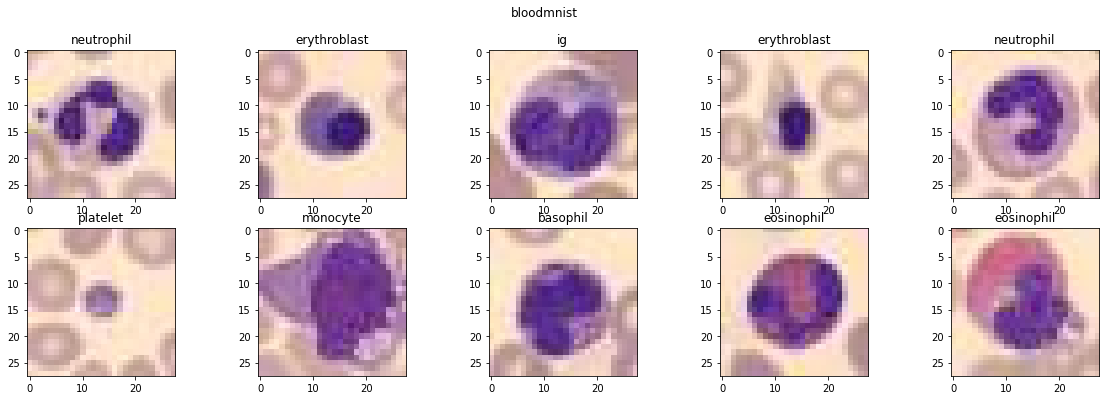

In [145]:
indices = random.sample(range(len(data.dataset_train)), 10)
data_subset = itemgetter(*indices)(data.dataset_train)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 6))
plt.suptitle(medmnist_dataset)
for i, ax in enumerate(axs.ravel()):
    image, annotation = data_subset[i]
    if len(image.shape) == 3:
        image = image.permute(1, 2, 0).numpy().astype(np.uint8)
    elif len(image.shape) == 4:
        image = image[0][14]
    label = data.dataset_train.labels[str(annotation.short().item())]
    ax.imshow(image, cmap="gray")
    ax.set_title(label)

### Show Model Information

In [146]:
monai_lightning_model = MonaiModel(monai_model=monai_model, config=default_config)
summarize(monai_lightning_model)

Initialized DenseNet with settings: {'in_channels': 3, 'out_channels': 8, 'spatial_dims': 2, 'block_config': [6, 12, 8]} 8 classes


  | Name          | Type             | Params
---------------------------------------------------
0 | _model        | DenseNet         | 2.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.458     Total estimated model params size (MB)

## Start Training

Create a PyTorch Lightning [Trainer](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html) and call the `.fit()` method to start training. Set `USE_CUDA` to True to enable training on CUDA-enabled GPUs and adjust the other settings as needed. The settings below train the model for 5 epochs, log to TensorBoard, and save the best 3 checkpoints, where "best" is defined as highest accuracy. On CUDA, 16 bit training is enabled. This is not supported on CPU. `limit_train_batches` can be useful for large datasets. At the end of training, the total training duration will be displayed.

See the [documentation](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html) for information on all parameters and settings.

Uncomment the next cell to show a TensorBoard dashboard in the notebook. This will initially show no data. Click on the refresh button in the TensorBoard cell to show data during and after training.

To cancel training, click the stop button in the Jupyter toolbar at the top of the notebook. That will stop gracefully: the best checkpoint until that point is saved.

In [147]:
# %load_ext tensorboard
# %tensorboard --logdir tb_logs --bind_all

In [149]:
logger = TensorBoardLogger("tb_logs", name=f"{medmnist_dataset}_{monai_model.lower()}")
checkpoint_callback = ModelCheckpoint(
    monitor="validate_accuracy", mode="max", save_top_k=1
)
# Ignore PyTorch Lightning warnings about possible improvements
warnings.filterwarnings(
    "ignore", ".*increasing the value of the `num_workers` argument*"
)
warnings.filterwarnings("ignore", ".*smaller than the logging interval*")
warnings.filterwarnings("ignore", ".*has already been called*")

limit_train_batches = 1.0
limit_val_batches = 1.0

# For demonstration purposes, we limit the number of dataset items for large datasets to reduce
# training time. This may impact accuracy.
if len(data.train_dataloader().dataset) > 6000:
    limit_train_batches = 1 / (len(data.train_dataloader().dataset) / 6000)
if len(data.val_dataloader().dataset) > 5000:
    limit_val_batches = 0.5

USE_CUDA = torch.cuda.is_available()
trainer = pl.Trainer(
    max_epochs=5,
    gpus=1 if USE_CUDA else 0,
    logger=logger,
    precision=16 if USE_CUDA else 32,
    limit_train_batches=limit_train_batches,
    limit_val_batches=limit_val_batches,
    callbacks=[checkpoint_callback],
    fast_dev_run=False,  # set to True to quickly test the Lightning model
)

start = datetime.datetime.now()
try:
    trainer.fit(model=monai_lightning_model, datamodule=data)
finally:
    end = datetime.datetime.now()
    delta = dateutil.relativedelta.relativedelta(end, start)
    print(
        f"Training duration: {delta.hours:02d}:{delta.minutes:02d}:{delta.seconds:02d}"
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | _model        | DenseNet         | 2.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.458     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training duration: 00:03:09


### Evaluate Trained Model on Validation and Test Set

In [150]:
torch_val_accuracy = trainer.validate(ckpt_path="best", dataloaders=data)
torch_test_accuracy = trainer.test(ckpt_path="best", dataloaders=data)

Restoring states from the checkpoint path at tb_logs/bloodmnist_densenet/version_1/checkpoints/epoch=3-step=1259.ckpt
Loaded model weights from checkpoint at tb_logs/bloodmnist_densenet/version_1/checkpoints/epoch=3-step=1259.ckpt


Validating: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at tb_logs/bloodmnist_densenet/version_1/checkpoints/epoch=3-step=1259.ckpt
Loaded model weights from checkpoint at tb_logs/bloodmnist_densenet/version_1/checkpoints/epoch=3-step=1259.ckpt


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'validate_accuracy': 0.8317757248878479, 'validate_loss': 0.4426080286502838}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.81993567943573, 'test_loss': 0.4642804265022278}
--------------------------------------------------------------------------------


Visualize images from the test set and print actual and predicted labels

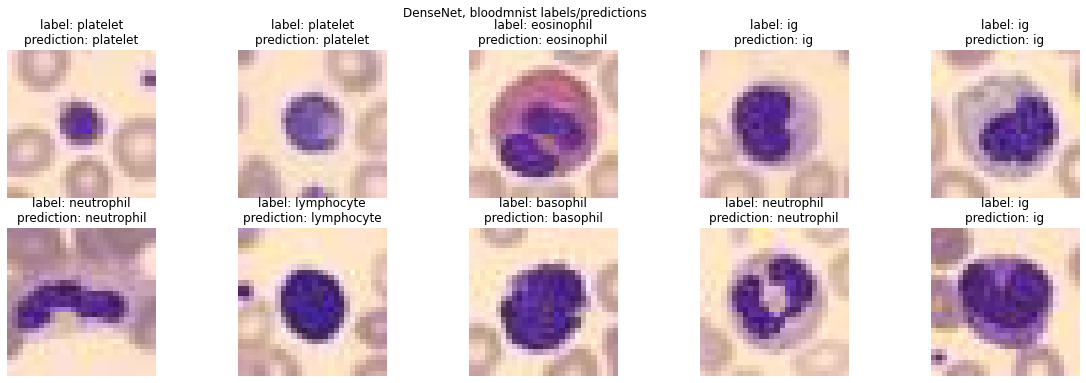

In [151]:
indices = random.sample(range(len(data.dataset_test)), 10)
data_subset = itemgetter(*indices)(data.dataset_test)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 6))
plt.suptitle(f"{monai_model}, {medmnist_dataset} labels/predictions")
monai_lightning_model.eval()

for i, ax in enumerate(axs.ravel()):
    image, annotation = data_subset[i]
    prediction = monai_lightning_model.predict_one(image.unsqueeze(0)).item()
    if len(image.shape) == 3:
        image = image.permute(1, 2, 0).numpy().astype(np.uint8)
    elif len(image.shape) == 4:
        image = image[0][14]
    target_label = f"label: {data.dataset_train.labels[str(annotation.short().item())]}"
    predicted_label = f"prediction: {data.dataset_train.labels[str(prediction)]}"

    ax.imshow(image, cmap="gray")
    ax.set_title(f"{target_label}\n{predicted_label}")
    ax.axis("off")

## Convert FP32 model to ONNX and IR

Load the best checkpoint and export the model to ONNX.

In [152]:
MODEL_DIR = Path("nncf_models")
MODEL_DIR.mkdir(exist_ok=True)
onnx_path = MODEL_DIR / f"{monai_model}_{medmnist_dataset}_fp32.onnx"
checkpoint_path = checkpoint_callback.best_model_path
best_model = MonaiModel.load_from_checkpoint(checkpoint_path).cpu().eval()

if data.dataset_train.num_dims == 3:
    input_shape = [1, data.dataset_train.num_channels, 28, 28, 28]
else:
    input_shape = [1, data.dataset_train.num_channels, 28, 28]


dummy_input = torch.randn(*input_shape)
torch.onnx.export(best_model, dummy_input, onnx_path, opset_version=10)
print(f"Exported ONNX model to {onnx_path}")

# Convert ONNX model and export to OpenVINO IR
fp_ir_path = onnx_path.with_suffix(".xml")
IECore().read_network(onnx_path).serialize(str(fp_ir_path))
print(f"Exported FP32 IR model to {fp_ir_path}")

Initialized DenseNet with settings: {'in_channels': 3, 'out_channels': 8, 'spatial_dims': 2, 'block_config': [6, 12, 8]} 8 classes
Exported ONNX model to nncf_models/DenseNet_bloodmnist_fp32.onnx
Exported FP32 IR model to nncf_models/DenseNet_bloodmnist_fp32.xml


## Quantize Model with NNCF

Creating an [NNCF](https://github.com/openvinotoolkit/nncf) compressed model requires a configuration dictionary, a dataloader, and a model. We use the `best_model` loaded in the previous cell, and use the validation dataloader. 

In [153]:
NNCF_OUTPUT_DIR = Path("output")
NNCF_OUTPUT_DIR.mkdir(exist_ok=True)
input_shape = list(next(iter(data.val_dataloader()))[0].shape)
input_shape[0] = 1
set_log_level(logging.ERROR)  # Disables all NNCF info and warning messages
nncf_config_dict = {
    "input_info": {"sample_size": input_shape},
    "log_dir": str(NNCF_OUTPUT_DIR),
    "compression": {
        "algorithm": "quantization",
    },
}
nncf_config = NNCFConfig.from_dict(nncf_config_dict)
nncf_config = register_default_init_args(nncf_config, data.val_dataloader())

compression_ctrl, compressed_model = create_compressed_model(
    best_model._model, nncf_config
)
del best_model

### Export Quantized Model to ONNX and OpenVINO IR.

The quantized model can be exported to ONNX with NNCF's `export_model` method. We then export to OpenVINO IR. The ONNX modelfile will have the same size as the PyTorch model file. The quantized IR model file will have a smaller size.

In [154]:
warnings.filterwarnings("ignore", category=TracerWarning)
warnings.filterwarnings("ignore", category=UserWarning)

int8_onnx_path = MODEL_DIR / f"{monai_model}_{medmnist_dataset}_nncf.onnx"
compression_ctrl.export_model(int8_onnx_path)

### Convert to OpenVINO IR

We use Model Optimizer to convert the ONNX model to OpenVINO's Intermediate Representation (IR) format. This step reduces the file size of the model. 

In Jupyter we can call it with `! mo`, in a script we can use the subprocess module. We use subprocess here, to make it easy to convert this notebook to a script.

For ONNX conversion, Model Optimizer only needs a path to an input model. We also specify an `output_dir` to save the model. Model Optimizer creates an .xml and .bin file, with the same base filename as the ONNX model. The .xml file contains information about the network topology, the .bin file contains weights and biases binary data. By default, weights and biases are stored as FP32. To convert them to FP16, set `--data_type` to FP16. This saves space (FP16 takes half as much space as FP32), and increases inference speed when using an Intel integrated GPU. 

Run `!mo --help` to see information about all Model Optimizer parameters

In [155]:
mo_result = subprocess.run(
    ["mo", "--input_model", int8_onnx_path, "--output_dir", MODEL_DIR],
    check=False,
    universal_newlines=True,
    capture_output=True,
)
if mo_result.returncode == 0:
    print(
        "\n".join([line for line in mo_result.stdout.split("\n") if "SUCCESS" in line])
    )
else:
    mo_error = "\n".join([line for line in mo_result.stderr.split("\n")])
    raise RuntimeError(
        f"Model optimization failed with the following error:\n{mo_error}"
    )

[ SUCCESS ] Generated IR version 10 model.
[ SUCCESS ] XML file: /home/helena/code/openvino-monai/medmnist/nncf_models/DenseNet_bloodmnist_nncf.xml
[ SUCCESS ] BIN file: /home/helena/code/openvino-monai/medmnist/nncf_models/DenseNet_bloodmnist_nncf.bin
[ SUCCESS ] Total execution time: 20.73 seconds. 
[ SUCCESS ] Memory consumed: 129 MB. 


## Compare Size of FP32 and INT8 Models

In [156]:
int8_ir_path = int8_onnx_path.with_suffix(".xml")

original_model_size = Path(fp_ir_path).with_suffix(".bin").stat().st_size / 1024 / 1024
quantized_model_size = (
    Path(int8_ir_path).with_suffix(".bin").stat().st_size / 1024 / 1024
)
int8_ir_path = int8_onnx_path.with_suffix(".xml")

print(f"FP32 model size: {original_model_size:.2f} MB")
print(f"INT8 model size: {quantized_model_size:.2f} MB")

FP32 model size: 8.12 MB
INT8 model size: 2.09 MB


## Compare Accuracy of PyTorch, FP32 and INT8 Models

We compare the accuracy of the models on the validation and test set. We use both MONAI's ConfusionMatrixMetric and MedMNIST's Evaluator. Accuracy is computed as the number of correct predictions divided by the total number of predictions. For imbalanced datasets another [MONAI Metric](https://docs.monai.io/en/latest/metrics.html) may be more suitable. 

We also show a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

In [157]:
def predict_ir(exec_net, image, return_class_index: bool = True):
    """
    Do inference of image on exec_net. Return the result as class index integer
    """
    input_layer = next(iter(exec_net.input_info))
    output_layer = next(iter(exec_net.outputs))
    output = exec_net.infer(inputs={input_layer: image})[output_layer]
    if return_class_index:
        output_shape = exec_net.outputs[output_layer].shape
        if output_shape[-1] == 1:
            predicted_class_index = sigmoid(output).round().astype(np.uint8).squeeze()
        else:
            predicted_class_index = np.argmax(output, axis=1).astype(np.uint8).squeeze()
        result = predicted_class_index
    else:
        result = output
    return result

In [158]:
def compute_accuracy(exec_net, dataset, num_classes):
    metric = ConfusionMatrixMetric(metric_name=["hit_rate"])
    cm = np.zeros((num_classes, num_classes), dtype=int)
    y_score = torch.tensor([])
    y_label = torch.tensor([])

    for image, label in dataset:

        output = predict_ir(exec_net, image, return_class_index=False)
        if num_classes > 2:
            softmax_outputs = torch.as_tensor(output).softmax(dim=-1)
        else:
            softmax_outputs = torch.sigmoid(torch.as_tensor(output))
        y_score = torch.cat((y_score, softmax_outputs), 0)
        label_ = label.float().resize_(len(label), 1)
        y_label = torch.cat((y_label, label_), 0)

        if len(label.shape) == 1:
            label.unsqueeze_(-1)

        is_binary_classification = num_classes <= 2
        output_transforms = Compose(
            [
                ToTensor(),
                Activations(sigmoid=is_binary_classification),
                AsDiscrete(threshold=0.5 if is_binary_classification else None),
                AsDiscrete(to_onehot=num_classes, argmax=not is_binary_classification),
            ]
        )
        target_transforms = Compose([ToTensor(), AsDiscrete(to_onehot=num_classes)])

        onehot_output = [output_transforms(item) for item in output]
        onehot_target = [target_transforms(item) for item in label]
        class_prediction = onehot_output[0].argmax().item()
        cm[int(label.item()), class_prediction] += 1

        metric(onehot_output, onehot_target)
    return metric.aggregate()[0].item(), cm, y_score, y_label

In [159]:
# Load IR and PyTorch Lightning Models
ie = IECore()
fp_net = ie.read_network(fp_ir_path)
fp_exec_net = ie.load_network(fp_net, "CPU")
int8_net = ie.read_network(int8_ir_path)
int8_exec_net = ie.load_network(int8_net, "CPU")
best_model = MonaiModel.load_from_checkpoint(checkpoint_path).cpu().eval()
num_classes = monai_lightning_model.num_classes

Initialized DenseNet with settings: {'in_channels': 3, 'out_channels': 8, 'spatial_dims': 2, 'block_config': [6, 12, 8]} 8 classes


### Compute Accuracy

Compute the accuracy, and show classification report and confusion matrix for the validation set. Set `SPLIT` to "test" to show the metrics for the test set.

In [160]:
SPLIT = "val"  # choose "val" or "test"
validation_dataset = MedMNISTDataset(medmnist_dataset=medmnist_dataset, split=SPLIT)
fp_acc, fp_cm, fp_y_score, fp_y_label = compute_accuracy(
    fp_exec_net, validation_dataset, num_classes
)
int8_acc, int8_cm, int8_y_score, int8_y_label = compute_accuracy(
    int8_exec_net, validation_dataset, num_classes
)

pytorch_acc = (
    torch_val_accuracy[0]["validate_accuracy"]
    if SPLIT == "val"
    else torch_test_accuracy[0]["test_accuracy"]
)
print(f"{SPLIT} accuracy of the PyTorch model: {pytorch_acc:.5f}")
print(f"{SPLIT} accuracy of the original IR model: {fp_acc:.5f}")
print(f"{SPLIT} accuracy of the quantized IR model: {int8_acc:.5f}")

Setup bloodmnist val, 3 channels, 8 classes
Using downloaded and verified file: /home/helena/.medmnist/bloodmnist.npz
val accuracy of the PyTorch model: 0.83178
val accuracy of the original IR model: 0.83178
val accuracy of the quantized IR model: 0.88143


MedMNIST offers a method to show the accuracy and AUC on a specific datasets. We use it to verify that the accuracy as computed by MedMNIST is the same as the accuracy computed in the cell above, with the method that was also used during model training. MedMNIST also computes the AUC. Benchmark results for accuracy and AUC are reported on the [MedMNIST website](https://medmnist.com/).

In [161]:
evaluator = Evaluator(medmnist_dataset, SPLIT)
metrics = evaluator.evaluate(np.array(int8_y_score))

print(f"MedMNIST_AUC: {metrics.AUC:.5f}")
print(f"MedMNIST_ACC: {metrics.ACC:.5f}")

MedMNIST_AUC: 0.98873
MedMNIST_ACC: 0.88143


scikit-learn's [classification_report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) gives an at-a-glance overview of the model's performance with more detail than a single accuracy score. We show a classification report for the quantized model.

In [162]:
labels = data.dataset_train.labels.values()
if num_classes <= 2:
    predictions = int8_y_score.round().long().squeeze()
    print(classification_report(int8_y_label, predictions, target_names=labels))
else:
    predictions = int8_y_score.argmax(dim=1)
    print(classification_report(int8_y_label, predictions, target_names=labels))

              precision    recall  f1-score   support

    basophil       0.78      0.72      0.75       122
  eosinophil       0.98      0.98      0.98       312
erythroblast       0.84      0.96      0.90       155
          ig       0.76      0.64      0.70       290
  lymphocyte       0.83      0.92      0.87       122
    monocyte       0.70      0.81      0.75       143
  neutrophil       0.97      0.95      0.96       333
    platelet       0.98      1.00      0.99       235

    accuracy                           0.88      1712
   macro avg       0.86      0.87      0.86      1712
weighted avg       0.88      0.88      0.88      1712



A [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) gives exact information on how well the model performs on each label. 

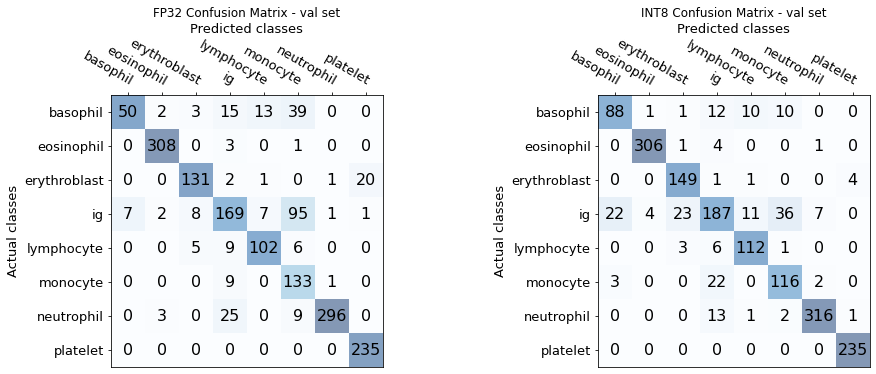

In [163]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

fp_im = axs[0].imshow(fp_cm / fp_cm.sum(axis=0), cmap="Blues", alpha=0.5)
int8_im = axs[1].imshow(int8_cm / int8_cm.sum(axis=0), cmap="Blues", alpha=0.5)

labels = data.dataset_train.labels.values()
# Show all ticks and label them with the respective list entries
for ax in axs:
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    ax.set_xticks(np.arange(num_classes), labels=labels)
    ax.set_yticks(np.arange(num_classes), labels=labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(
        ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor", size=13
    )
    plt.setp(ax.get_yticklabels(), size=13)
    ax.set_ylabel("Actual classes", size=13)
    ax.set_xlabel("Predicted classes", size=13)
    ax.xaxis.set_label_position("top")

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = axs[0].text(
            j, i, fp_cm[i, j], ha="center", va="center", color="black", size=16
        )
        text = axs[1].text(
            j, i, int8_cm[i, j], ha="center", va="center", color="black", size=16
        )
axs[0].set_title(f"FP32 Confusion Matrix - {SPLIT} set")
axs[1].set_title(f"INT8 Confusion Matrix - {SPLIT} set");

## Visually Compare Inference Results

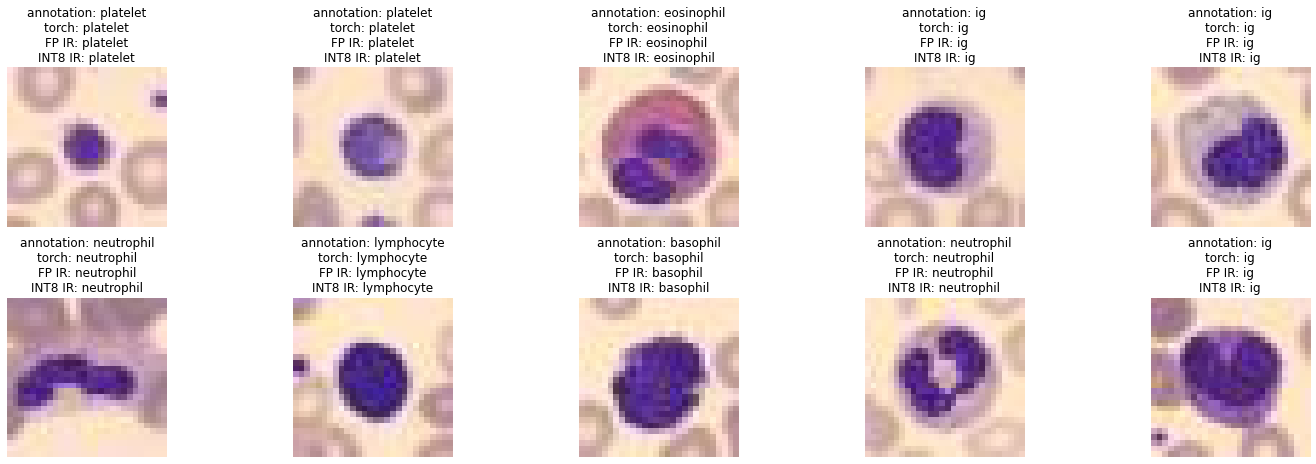

In [164]:
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))


# Load 10 random images. Run this cell again to see inference results on
# 10 different images
indices = random.sample(range(len(data.dataset_test)), 10)
data_subset = itemgetter(*indices)(data.dataset_test)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 6))
fig.tight_layout(h_pad=5)
monai_lightning_model.eval()

for i, ax in enumerate(axs.ravel()):
    image, annotation = data_subset[i]
    input_image = image.unsqueeze(0)
    torch_prediction = best_model.predict_one(input_image).item()
    fp_ir_prediction = predict_ir(fp_exec_net, input_image)
    int8_ir_prediction = predict_ir(int8_exec_net, input_image)

    if len(image.shape) == 3:
        image = image.permute(1, 2, 0).numpy().astype(np.uint8)
    elif len(image.shape) == 4:
        image = image[0][14]
    target_label = (
        f"annotation: {data.dataset_train.labels[str(annotation.short().item())]}"
    )
    torch_predicted_label = f"torch: {data.dataset_train.labels[str(torch_prediction)]}"
    fp_predicted_label = f"FP IR: {data.dataset_train.labels[str(fp_ir_prediction)]}"
    int8_predicted_label = (
        f"INT8 IR: {data.dataset_train.labels[str(int8_ir_prediction)]}"
    )
    ax.imshow(image, cmap="gray")
    ax.set_title(
        f"{target_label}\n{torch_predicted_label}\n{fp_predicted_label}\n{int8_predicted_label}"
    )
    ax.axis("off")

## Benchmark Performance

To measure the inference performance of the FP16 and INT8 models, we use [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html#doxid-openvino-inference-engine-tools-benchmark-tool-r-e-a-d-m-e), OpenVINO's inference performance measurement tool. Benchmark tool is a command line application that can be run in the notebook with ! benchmark_app or %sx benchmark_app.

In the next cell, we create a wrapper function for `benchmark_app` that prints the benchmark_app command with the chosen parameters. For comparison purposes, it filters logging information from the output of `benchmark_app`.

> NOTE: For the most accurate performance estimation, we recommended running benchmark_app in a terminal/command prompt after closing other applications. Run `benchmark_app --help` to see all command line options.

In [165]:
def benchmark_model(
    model_path: os.PathLike,
    device: str = "CPU",
    seconds: int = 60,
    api: str = "async",
    batch: int = 1,
    cache_dir: str = "model_cache",
    key: Optional[str] = None,
    input_shape: Optional[Sequence] = None,
):
    ie = IECore()
    model_path = Path(model_path)
    if ("GPU" in device) and ("GPU" not in ie.available_devices):
        raise ValueError(
            f"A GPU device is not available. Available devices are: {ie.available_devices}"
        )
    else:
        benchmark_command = f"benchmark_app -m {model_path} -d {device} -t {seconds} -api {api} -b {batch} -cdir {cache_dir}"
        if input_shape is not None:
            input_shape_str = f'[{",".join([str(item) for item in input_shape])}]'
            benchmark_command += f" -shape {input_shape_str}"

        display(
            Markdown(
                f"**Benchmark {model_path.name} {key} model on {device} for {seconds} seconds with {api} inference**"
            )
        )
        display(Markdown(f"Benchmark command: `{benchmark_command}`"))

        benchmark_output = subprocess.run(
            benchmark_command.split(" "), capture_output=True, universal_newlines=True
        )
        benchmark_result = [
            line.replace("Latency", f"{key}_Latency").replace(
                "Throughput", f"{key}_Throughput"
            )
            for line in benchmark_output.stdout.splitlines()
            if not (line.startswith(r"[") or line.startswith("  ") or line == "")
        ]
        print("\n".join(benchmark_result))
        print()
        if "MULTI" in device:
            devices = device.replace("MULTI:", "").split(",")
            for single_device in devices:
                print(
                    f"{single_device} device: {ie.get_metric(device_name=single_device, metric_name='FULL_DEVICE_NAME')}"
                )
        else:
            print(
                f"Device: {ie.get_metric(device_name=device, metric_name='FULL_DEVICE_NAME')}"
            )

<div class="alert-info">Performance on MedMNIST datasets with 28x28(x28) images is not indicative of performance with real data. Set `SET_BENCHMARK_SHAPE` to True in the cell below to specify a more realistic input size to `benchmark_app`, to get an indication of performance on real data.</div>

In [166]:
SET_BENCHMARK_SHAPE = True
if SET_BENCHMARK_SHAPE:
    if data.dataset_train.num_dims == 3:
        benchmark_shape = [1, data.dataset_train.num_channels, 128, 128, 128]
    else:
        benchmark_shape = [1, data.dataset_train.num_channels, 512, 512]
else:
    benchmark_shape = None

In [167]:
# FP model on CPU
benchmark_model(
    fp_ir_path,
    device="CPU",
    seconds=15,
    api="sync",
    key="FP32",
    input_shape=benchmark_shape,
)

**Benchmark DenseNet_bloodmnist_fp32.xml FP32 model on CPU for 15 seconds with sync inference**

Benchmark command: `benchmark_app -m nncf_models/DenseNet_bloodmnist_fp32.xml -d CPU -t 15 -api sync -b 1 -cdir model_cache -shape [1,3,512,512]`

Count:      224 iterations
Duration:   15003.00 ms
FP32_Latency:    66.52 ms
FP32_Throughput: 15.03 FPS

Device: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz


In [124]:
# INT8 model on CPU
benchmark_model(
    int8_ir_path,
    device="CPU",
    seconds=15,
    api="sync",
    key="INT8",
    input_shape=benchmark_shape,
)

**Benchmark DenseNet_breastmnist_nncf.xml INT8 model on CPU for 15 seconds with sync inference**

Benchmark command: `benchmark_app -m nncf_models/DenseNet_breastmnist_nncf.xml -d CPU -t 15 -api sync -b 1 -cdir model_cache -shape [1,1,512,512]`

Count:      646 iterations
Duration:   15009.55 ms
INT8_Latency:    23.10 ms
INT8_Throughput: 43.29 FPS

Device: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz
